In [53]:
import pyspark as ps
import pandas as pd
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
from pyspark.sql.functions import substring, count, concat, col, lit, round, when, unix_timestamp, date_format, month, year, udf
from pyspark.sql import types
import json
import time
import requests

#  Getting Started

## Download Data

Using cURL instead of Kaggle cause kagglehub only downloads to outside your project directory and Kaggle needs authentification...
 
uhhhe, gross!

In [65]:
!curl -L -o archive.zip https://www.kaggle.com/api/v1/datasets/download/sobhanmoosavi/us-accidents

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 67  653M   67  444M    0     0  39.7M      0  0:00:16  0:00:11  0:00:05 42.4M^C


In [26]:
!unzip archive.zip

Archive:  archive.zip
  inflating: US_Accidents_March23.csv  


## Create Spark Session

I'll use pyspark first cause it's optimized for large data. By the end of the section we will output a pandas dataframe which is more familiar to everybody.

In [114]:
# Initialize Spark Session
spark = SparkSession.builder.appName("US_Accidents_Analysis").getOrCreate()

# Load the CSV file into a DataFrame
df = spark.read.option("header", "true").option("inferSchema", "true").csv("US_Accidents_March23.csv")

In [115]:
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

# Data Cleaning

## Drop Unusable Variables

Some of the variables simply don't make sense and will not contribute to our model.

Some are debatable.

### Assess weather condition stay or leave

In [116]:
df.select("Weather_Condition").distinct().collect()

[Row(Weather_Condition='Ice Pellets'),
 Row(Weather_Condition='Shallow Fog'),
 Row(Weather_Condition='Thunderstorm'),
 Row(Weather_Condition='Volcanic Ash'),
 Row(Weather_Condition='N/A Precipitation'),
 Row(Weather_Condition='Showers in the Vicinity'),
 Row(Weather_Condition='Cloudy'),
 Row(Weather_Condition='Light Freezing Rain'),
 Row(Weather_Condition='Blowing Snow'),
 Row(Weather_Condition='Heavy Rain / Windy'),
 Row(Weather_Condition='Low Drifting Snow'),
 Row(Weather_Condition='Heavy Thunderstorms and Snow'),
 Row(Weather_Condition='Widespread Dust'),
 Row(Weather_Condition='Snow Grains'),
 Row(Weather_Condition='Light Rain with Thunder'),
 Row(Weather_Condition='Squalls'),
 Row(Weather_Condition='Scattered Clouds'),
 Row(Weather_Condition='Heavy T-Storm'),
 Row(Weather_Condition='Patches of Fog'),
 Row(Weather_Condition='Rain Showers'),
 Row(Weather_Condition='Thunderstorms and Rain'),
 Row(Weather_Condition='Drizzle'),
 Row(Weather_Condition='Cloudy / Windy'),
 Row(Weather_Con

Weather condition has too many variables.. we drop it for now cause other numeric parameters should be sufficient.

### Assess day/night condition stay or leave

In [117]:
df.select("Sunrise_Sunset").distinct().show()

+--------------+
|Sunrise_Sunset|
+--------------+
|         Night|
|           Day|
|          NULL|
+--------------+



It'll stay as a boolean.

In [118]:
df = df.withColumn(
    "Day_Night",
    when(col("Sunrise_Sunset") == "Day", 1)
    .when(col("Sunrise_Sunset") == "Night", 0)
    .otherwise(None)  # You can replace None with a value, such as -1, to handle NULL cases
)

### Assess Wind Direction stay or leave

In [119]:
df.select("Wind_Direction").distinct().show()

+--------------+
|Wind_Direction|
+--------------+
|           SSE|
|            SW|
|            NW|
|          Calm|
|             E|
|           WSW|
|           ENE|
|            NE|
|         South|
|           NNW|
|             N|
|           SSW|
|             W|
|             S|
|            SE|
|          East|
|           WNW|
|           NNE|
|          West|
|           VAR|
+--------------+
only showing top 20 rows



I'll drop it.

### Start Dropping

Some of the variables simply don't make sense and will not contribute to our model.

In [120]:
# Drop the unnecessary columns including ID and Source
df_cleaned = df.drop("Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Description", "ID", "Source", 
                     "Distance", "Street", "City", "County", "State", "Country", "Timezone", "Airport_code", 
                     "Weather_Condition", "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", 
                     "Roundabout", "Weather_Timestamp", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", 
                     "Astronomical_Twilight", "Nautical_Twilight", "Civil_Twilight", "Wind_Direction")

# Show the first 5 rows of the cleaned DataFrame to verify the columns were removed
df_cleaned.show(5, truncate=False)

+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+---------+
|Severity|Start_Time         |End_Time           |Distance(mi)|Zipcode   |Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Day_Night|
+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+---------+
|3       |2016-02-08 05:46:00|2016-02-08 11:00:00|0.01        |45424     |36.9          |NULL         |91.0       |29.68       |10.0          |NULL           |0.02             |Night         |0        |
|2       |2016-02-08 06:07:59|2016-02-08 06:37:59|0.01        |43068-3402|37.9          |NULL         |100.0      |29.65       |10.0          |NULL           |0.0              |Night      

In [121]:
df = df_cleaned

## Drop Null

In [122]:
df.count()

7728394

In [123]:
df = df.dropna()

In [124]:
df.count()

5227106

## Create Duration feature

In [125]:
df = df.withColumn(
    "duration_minutes",
    (unix_timestamp(col("end_time")) - unix_timestamp(col("start_time"))) / 60
)

In [126]:
df.show(5)

+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+---------+----------------+
|Severity|         Start_Time|           End_Time|Distance(mi)|   Zipcode|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Day_Night|duration_minutes|
+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+---------+----------------+
|       3|2016-02-08 07:44:26|2016-02-08 08:14:26|        0.01|     43081|          37.9|         35.5|       97.0|       29.63|           7.0|            3.5|             0.03|           Day|        1|            30.0|
|       3|2016-02-08 08:10:04|2016-02-08 08:40:04|        0.01|     43081|          37.4|         33.8|      100.0|     

## Create Day, Month, Year Categorical Variables

In [127]:
# Step 1: Extract "day_of_week" as a string, "month", and "year"
df = df.withColumn("day_of_week_str", date_format(col("start_time"), "E")) \
       .withColumn("month", month(col("start_time"))) \
       .withColumn("year", year(col("start_time")))

# Step 2: Map the day_of_week_str to numeric values (Mon = 1, ..., Sun = 7)
df = df.withColumn(
    "day_of_week",
    when(col("day_of_week_str") == "Mon", 1)
    .when(col("day_of_week_str") == "Tue", 2)
    .when(col("day_of_week_str") == "Wed", 3)
    .when(col("day_of_week_str") == "Thu", 4)
    .when(col("day_of_week_str") == "Fri", 5)
    .when(col("day_of_week_str") == "Sat", 6)
    .when(col("day_of_week_str") == "Sun", 7)
    .otherwise(None)
)

# Step 3: (Optional) Drop the "day_of_week_str" column if you no longer need it
df = df.drop("day_of_week_str")
df.show(5)

+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+---------+----------------+-----+----+-----------+
|Severity|         Start_Time|           End_Time|Distance(mi)|   Zipcode|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Day_Night|duration_minutes|month|year|day_of_week|
+--------+-------------------+-------------------+------------+----------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+---------+----------------+-----+----+-----------+
|       3|2016-02-08 07:44:26|2016-02-08 08:14:26|        0.01|     43081|          37.9|         35.5|       97.0|       29.63|           7.0|            3.5|             0.03|           Day|        1|            30.0|    2|2016|          1|
|       3|2016-02-08 08:10:0

## Geolocation Processing - ZIP Code to Population

Due to an imbalance of geolocation data, I propose we use population as a continuous to replace ZIP code.

In [128]:
# First let's truncate zipcode to only 5 digits
df = df.withColumn("Zipcode", substring("Zipcode", 1, 5))

In [129]:
unique_zipcodes = [row["Zipcode"] for row in df.select("Zipcode").distinct().collect()]

### Imbalance of ZIP Code Distribution

In [130]:
len(unique_zipcodes)

20305

In [131]:
# Group by the first five digits of the zip code and count the occurrences
df_zipcode_histogram = df.groupBy("Zipcode").agg(count("*").alias("count"))

# Display the top 10 zip codes by frequency
df_zipcode_histogram.orderBy("count", ascending=False).show(10, truncate=False)

+-------+-----+
|Zipcode|count|
+-------+-----+
|33186  |10560|
|32819  |9841 |
|27610  |8768 |
|91761  |8610 |
|33155  |8341 |
|70808  |7764 |
|32837  |7753 |
|92407  |7592 |
|37211  |7480 |
|33169  |7395 |
+-------+-----+
only showing top 10 rows



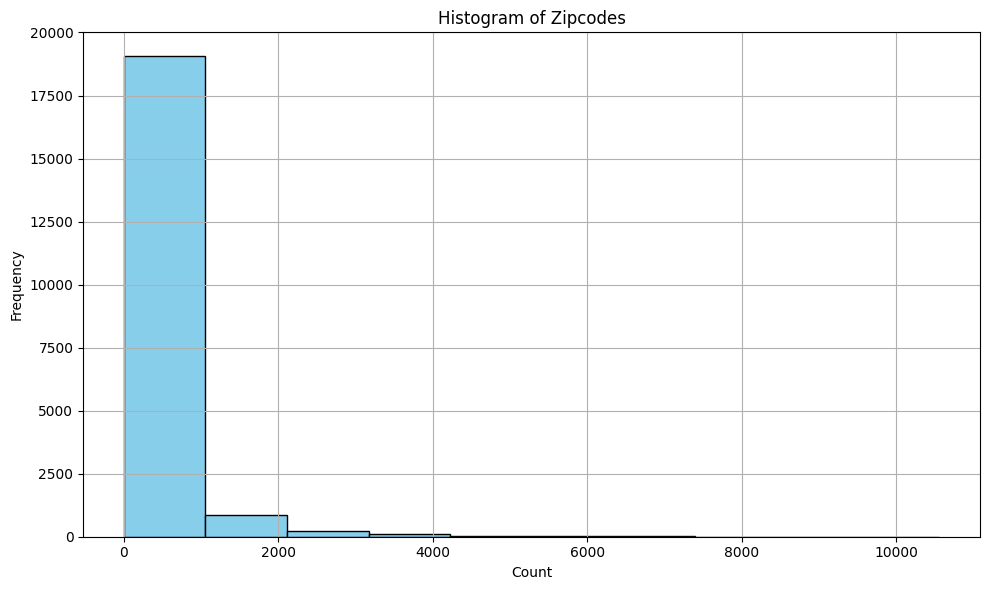

In [132]:
df_zipcode_histogram_pd = df_zipcode_histogram.toPandas()


plt.figure(figsize=(10, 6))
plt.hist(df_zipcode_histogram_pd['count'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Zipcodes')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### Calling Census API to Get Population by ZCTA

Go to this website
https://data.census.gov/table?q=demographics&g=860XX00US30318

Define function to request data from API.

Get an API key form the website above.

In [133]:
# Base URL for the Census ACS 2022 Profile API
BASE_URL = "https://api.census.gov/data/2022/acs/acs5/profile"

def get_population_data(output_path):
    params = {
        "get": "group(DP05)",
        "for": f"zip code tabulation area:*",
        "key": "67c2f8800849799333a9ee74d25c60a4630b3db1"
    }


    response = requests.get(BASE_URL, params=params)

    # Parse the JSON response
    data = response.json()

    population_dict = {}
    for i in range(1, len(data)):
        population_dict[int(data[i][-1])] = int(data[i][0])

    with open(output_path, "w") as file:
        json.dump(population_dict, file, indent=4)

    return population_dict

population_dict = get_population_data("population_data.json")

In [134]:

broadcast_population_dict = spark.sparkContext.broadcast(population_dict)

# Step 2: Define the UDF to get population based on zipcode, using the broadcast variable
def get_population(zipcode):
    return broadcast_population_dict.value.get(zipcode, None)  # Returns None if zipcode is not found

# Create the UDF with the specified return type
population_udf = udf(get_population, types.IntegerType())

# Step 3: Apply the UDF to create the "zipcode_population" column
df = df.withColumn("Zipcode", col("Zipcode").cast("int"))
df = df.withColumn("zipcode_population", population_udf(col("Zipcode")))

In [135]:
df.show(5)

+--------+-------------------+-------------------+------------+-------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+---------+----------------+-----+----+-----------+------------------+
|Severity|         Start_Time|           End_Time|Distance(mi)|Zipcode|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Sunrise_Sunset|Day_Night|duration_minutes|month|year|day_of_week|zipcode_population|
+--------+-------------------+-------------------+------------+-------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+--------------+---------+----------------+-----+----+-----------+------------------+
|       3|2016-02-08 07:44:26|2016-02-08 08:14:26|        0.01|  43081|          37.9|         35.5|       97.0|       29.63|           7.0|            3.5|             0.03|           Day|        1|            30.0|    2|2

Plot a histogram to see how population is distributed

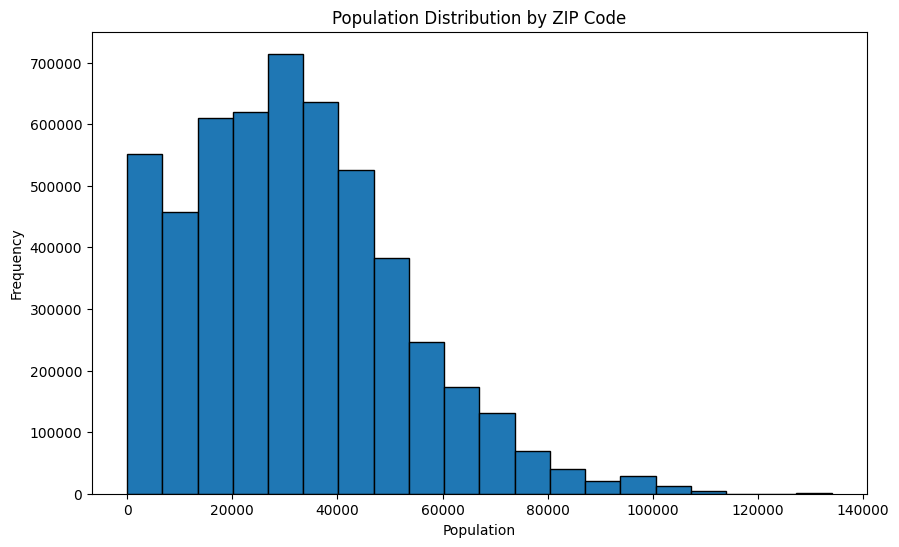

In [137]:
population_data = df.select("zipcode_population").dropna().rdd.flatMap(lambda x: x).collect()

# Plotting histogram with 20 bins
plt.figure(figsize=(10, 6))
plt.hist(population_data, bins=20, edgecolor='black')
plt.title("Population Distribution by ZIP Code")
plt.xlabel("Population")
plt.ylabel("Frequency")
plt.show()

Seems to work!

# Summary of Variables

In [136]:
df.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Zipcode: integer (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Sunrise_Sunset: string (nullable = true)
 |-- Day_Night: integer (nullable = true)
 |-- duration_minutes: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- zipcode_population: integer (nullable = true)



In [140]:
df.count()

5227106

Consolidate all the distributed data into one giant dataFrame, and then output to a path.

In [139]:
df.coalesce(1).write.csv("./cleaned_data", header=True, mode="overwrite")